## Enron Fraud Dataset 安隆公司詐欺案資料集
- 安隆公司曾是一間能源公司，2001 年破產前是世界上最大的電力、天然氣及電信公司之一。擁有上千億資產的公司於 2002 年竟然在短短幾周內宣告破產，才揭露其財報在多年以來均是造假的醜聞。在本資料集中你將會扮演偵探的角色，透過高層經理人內部的 mail 來往的情報以及薪資、股票等財務特徵，訓練出一個機器學習模型來幫忙你找到可疑的詐欺犯罪者是誰

### 評估
- 兩個 column，分別為員工姓名 (name)、嫌犯的預測機率值 (poi)
- 評估指標 AOC
- 輸出是犯罪者的機率並儲存為.csv檔為結果上傳。

In [249]:
# 事前準備
import os
import numpy as np          # 資料處理分析工具
import pandas as pd         # 資料處理分析工具
from scipy import stats     # 統計函式庫
from scipy.stats import norm, skew
from collections import Counter # counter是字典，用來計數，key是要計數的item，value儲存的是個數
from sklearn.preprocessing import LabelEncoder # 用於特徵提取, 將數值資料轉為離散
from sklearn.preprocessing import MinMaxScaler

# 匯入必要的函式庫
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# 資料視覺化
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette() # 生成各種顏色
sns.set_style('darkgrid') # 設置主題：darkgrid、whitegrid、dark、white、ticks
# 設定展示欄位最大值
pd.set_option('display.max_row', 200) 
pd.set_option('display.max_columns', 100) 

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

In [250]:
# 載入訓練資料集
train_data = pd.read_csv('./data/Enron Fraud/train_data.csv')
train_data.head(5)

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,True,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,True,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,True,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,True,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [251]:
# 載入測試資料集
test_features = pd.read_csv('./data/Enron Fraud/test_features.csv')
test_features.head(5)

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,BELDEN TIMOTHY N,5249999.0,2144013.0,-2334434.0,NaN,tim.belden@enron.com,953136.0,17355.0,484.0,228.0,108.0,NaN,NaN,210698.0,157569.0,NaN,213999.0,5521.0,7991.0,5501630.0,1110705.0
1,BOWEN JR RAYMOND M,1350000.0,NaN,-833.0,NaN,raymond.bowen@enron.com,NaN,65907.0,27.0,140.0,15.0,NaN,974293.0,1621.0,252055.0,NaN,278601.0,1593.0,1858.0,2669589.0,252055.0
2,HANNON KEVIN P,1500000.0,NaN,-3117011.0,NaN,kevin.hannon@enron.com,5538001.0,34039.0,32.0,32.0,21.0,NaN,1617011.0,11350.0,853064.0,NaN,243293.0,1035.0,1045.0,288682.0,6391065.0
3,DELAINEY DAVID W,3000000.0,NaN,NaN,NaN,david.delainey@enron.com,2291113.0,86174.0,3069.0,66.0,609.0,NaN,1294981.0,1661.0,1323148.0,NaN,365163.0,2097.0,3093.0,4747979.0,3614261.0
4,CAUSEY RICHARD A,1000000.0,NaN,-235000.0,NaN,richard.causey@enron.com,NaN,30674.0,49.0,58.0,12.0,NaN,350000.0,307895.0,2502063.0,NaN,415189.0,1585.0,1892.0,1868758.0,2502063.0


#### 觀察資料
- 發現只有name與email是字串
- poi為布林值

In [252]:
# 確認資料特徵類型
print(f'train_data dtypes:\n{train_data.dtypes}')
print(f'\ntrain_data shape: {train_data.shape}')
print(f'\ntest_features shape: {test_features.shape}')

train_data dtypes:
name                          object
bonus                        float64
deferral_payments            float64
deferred_income              float64
director_fees                float64
email_address                 object
exercised_stock_options      float64
expenses                     float64
from_messages                float64
from_poi_to_this_person      float64
from_this_person_to_poi      float64
loan_advances                float64
long_term_incentive          float64
other                        float64
poi                             bool
restricted_stock             float64
restricted_stock_deferred    float64
salary                       float64
shared_receipt_with_poi      float64
to_messages                  float64
total_payments               float64
total_stock_value            float64
dtype: object

train_data shape: (113, 22)

test_features shape: (33, 21)


#### 分析目標
- test資料集比起train資料集少了poi這個欄位，
- 此專案是藉由mail來往的情報以及薪資、股票等財務特徵來預測犯罪者 poi，True表示是，False表示否。

#### 數據清洗
- 移除不能用的資料

In [253]:
# 觀察哪些人的缺失值太多的人 例如大於18的，直接將其刪除
nan_index = []
for idx in train_data.index:
    if train_data.iloc[idx, :].isnull().sum()>15:
        nan_index.append(idx)
print(nan_index)
train_data.iloc[nan_index] 
train_data.drop(nan_index, axis = 0, inplace=True) # axis=0 代表刪除row

print(f'\ntrain_data shape: {train_data.shape}')

[17, 25, 30, 35, 38, 56, 61, 62, 65, 70, 73, 74, 76, 79, 94, 98, 100, 104, 105, 107]

train_data shape: (93, 22)


In [254]:
# 觀察資料後發現一個看起來不像人名，另一個則是全都是 NAN，將他們刪除
train_data = train_data[(train_data['name'] != "THE TRAVEL AGENCY IN THE PARK") & (train_data['name'] != "LOCKHART EUGENE E")]

# 確認資料特徵類型
print(f'\ntrain_data shape: {train_data.shape}')


train_data shape: (93, 22)


#### 離群值檢測

In [255]:
# 建立異常值index陣列
outlier_indices = []

# 計算每個特徵的四分位數
for column in train_data.columns:
    if column in ['name','email_address','poi']:
        continue # continue：強制跳出 ❮本次❯ 迴圈，繼續進入下一圈
    Q1 = train_data.loc[train_data[column].notna(), column].quantile(0.25) # 計算第一四分位數
    Q3 = train_data.loc[train_data[column].notna(), column].quantile(0.75) # 計算第三四分位數
    
    # 四分位數間距（IQR）是第一個四分位數與第三個四分位數之間的差值, 用於檢測異常值
    IQR = Q3 - Q1
    
    # 將 1.5 x（IQR）添加到第三个四分位数。任何大于此的数字或是小於此數字都是可疑的异常值。
    outlier_step = 1.5 * IQR
    
    # 取得是異常值的 index
    outlier_index = train_data[(train_data[column] < Q1 -outlier_step) | (train_data[column] > Q3 + outlier_step)].index
    
    # extend方法只能加入串列，不可以是元素。它會把串列中的元素做為個別元素加進串列裡 
    # 建立判定為異常值的陣列
    outlier_indices.extend(outlier_index)
    
# 選擇包含超過 n個異常值的觀察
outlier_indices = dict(Counter(outlier_indices))           # 將異常值的資料轉為字典
outlier_counts = pd.DataFrame.from_dict(outlier_indices, orient = 'index', columns=['counts']) # 將字典轉回dataframe形式
outlier_data = train_data.loc[outlier_indices.keys()]       # 取得異常值字典的 key的那些 row 資料
outlier_data = pd.concat([outlier_counts, outlier_data], axis = 1) # 將異常值計數的 dataframe 與 異常資料的 dataframe 合併
outlier_data.sort_values(by = ['counts'], ascending = False).head() # 觀察

,counts,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
8,8,LAY KENNETH L,7000000.0,202911.0,-300000.0,NaN,kenneth.lay@enron.com,34348384.0,99832.0,36.0,123.0,16.0,81525000.0,3600000.0,10359729.0,True,14761694.0,NaN,1072321.0,2411.0,4273.0,103559793.0,49110078.0
1,7,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
33,7,LAVORATO JOHN J,8000000.0,NaN,NaN,NaN,john.lavorato@enron.com,4158995.0,49537.0,2585.0,528.0,411.0,NaN,2035380.0,1552.0,False,1008149.0,NaN,339288.0,3962.0,7259.0,10425757.0,5167144.0
47,7,WHALLEY LAWRENCE G,3000000.0,NaN,NaN,NaN,greg.whalley@enron.com,3282960.0,57838.0,556.0,186.0,24.0,NaN,808346.0,301026.0,False,2796177.0,NaN,510364.0,3920.0,6019.0,4677574.0,6079137.0
58,5,BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,NaN,NaN,6680544.0,11200.0,NaN,NaN,NaN,NaN,1586055.0,2660303.0,False,3942714.0,NaN,267102.0,NaN,NaN,5634343.0,10623258.0


In [256]:
# 去除大於四個離群值的資料
outlier_drop = list(key for key, value in outlier_indices.items() if value >=4) # 取得異常值字典裡 value > 4 的 index
print("異常值過多的index: " + str(outlier_drop))
train_data = train_data.drop(outlier_drop, axis = 0).reset_index(drop=True) # drop=True可以去除index那一column

異常值過多的index: [1, 8, 14, 26, 33, 47, 75, 0, 58, 78, 112, 87]


#### 移除無法作為特徵的欄位
- 由於姓名沒有職稱(Mr. Misss.等稱謂)，email也沒有特別之處，所以刪掉。

In [257]:
# 移除'name','email_address'
train_name = train_data['name']
train_email_address = train_data['email_address']
test_name = test_features['name']
test_email_address = test_features['email_address']

# 觀察移除欄位後的資料及尺寸
y_train = train_data['poi']
train_data = train_data.drop(['name','email_address','poi'], axis = 1) # 刪除指定column
test_features = test_features.drop(['name', 'email_address'], axis = 1)

print('train_data shape: '+str(train_data.shape))
print('y_train shape: '+str(y_train.shape))
print('test_features shape: '+str(test_features.shape))

train_data shape: (81, 19)
y_train shape: (81,)
test_features shape: (33, 19)


#### 偏態檢查
- 去除偏態：若標準化後離群值比例過高或是平均值沒有代表性，就是資料不太像常態分佈、資料明顯偏一邊之類的，則可以透過去除偏態讓資料更接近常態分佈（左右對稱、中央更集中）
- np.log1p 先做數據平滑處理 使其更加服從高斯分布

In [258]:
# 合併 train & test 資料集
X = pd.concat([train_data, test_features], ignore_index = True)

# 觀察欄位型態
print(f'\ndtypes of each columns:\n{X.dtypes}')
# 觀察空值數
print(f'\nnumbers of NaN:\n{X.isnull().sum()}')
# 觀察相異數
print(f'\nnumbers of nunique:\n{X.nunique()}')


dtypes of each columns:
bonus                        float64
deferral_payments            float64
deferred_income              float64
director_fees                float64
exercised_stock_options      float64
expenses                     float64
from_messages                float64
from_poi_to_this_person      float64
from_this_person_to_poi      float64
loan_advances                float64
long_term_incentive          float64
other                        float64
restricted_stock             float64
restricted_stock_deferred    float64
salary                       float64
shared_receipt_with_poi      float64
to_messages                  float64
total_payments               float64
total_stock_value            float64
dtype: object

numbers of NaN:
bonus                         44
deferral_payments             79
deferred_income               75
director_fees                105
exercised_stock_options       33
expenses                      38
from_messages                 38
from_poi_t

Text(0.5, 1.0, 'total_stock_value')

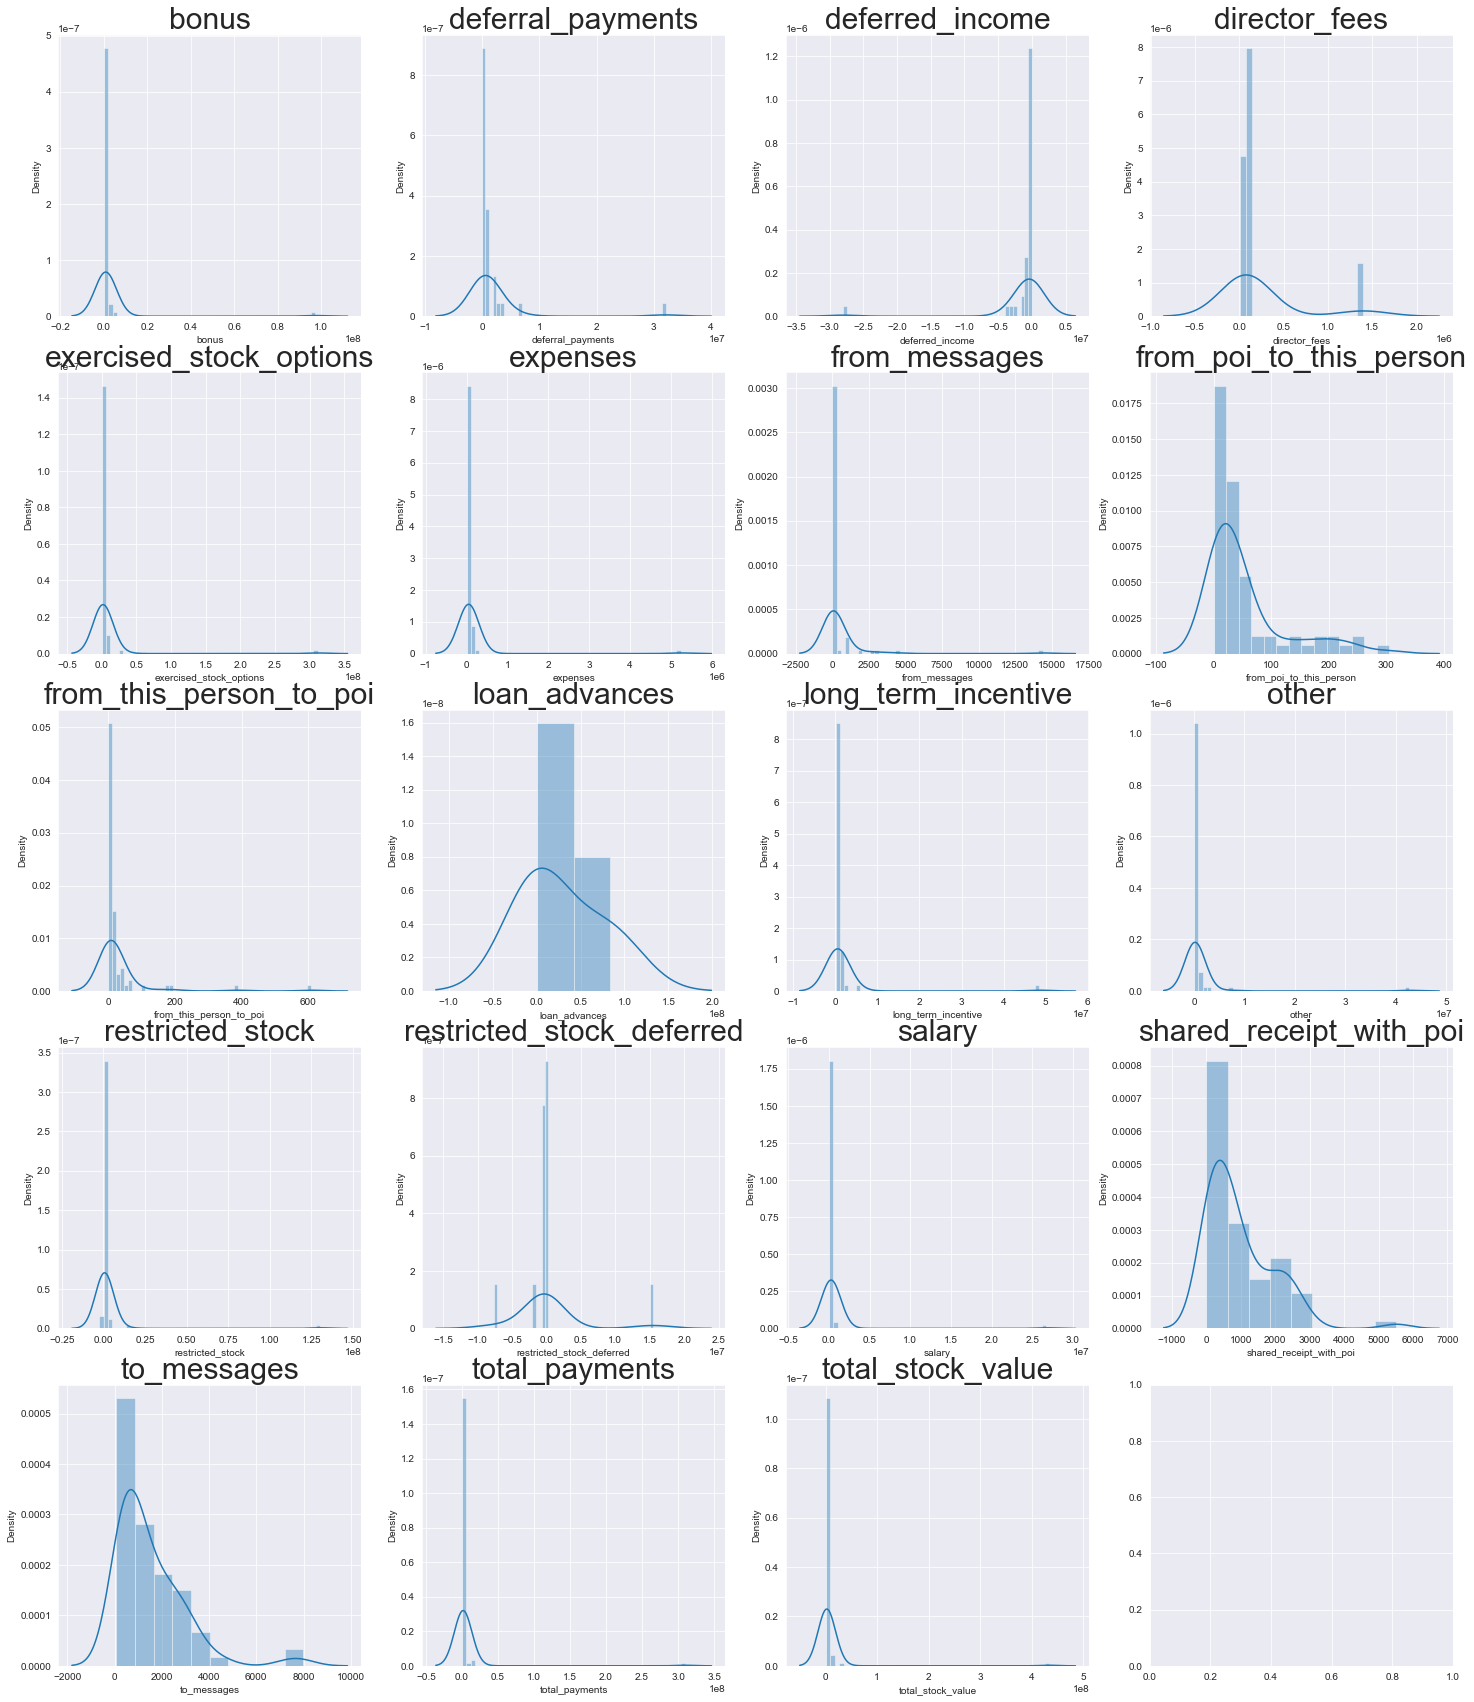

In [259]:
# 觀察特徵值
# 使用 distplot 結合了直方圖與和密度估計圖
f, ax = plt.subplots(5, 4, figsize=(25, 30))
sns.distplot(X['bonus'].dropna(), ax = ax[0, 0])
sns.distplot(X['deferral_payments'].dropna(), ax = ax[0, 1])
sns.distplot(X['deferred_income'].dropna(), ax = ax[0, 2])
sns.distplot(X['director_fees'].dropna(), ax = ax[0, 3])
sns.distplot(X['exercised_stock_options'].dropna(), ax = ax[1, 0])
sns.distplot(X['expenses'].dropna(), ax = ax[1, 1])
sns.distplot(X['from_messages'].dropna(), ax = ax[1, 2])
sns.distplot(X['from_poi_to_this_person'].dropna(), ax = ax[1, 3])
sns.distplot(X['from_this_person_to_poi'].dropna(), ax = ax[2, 0])
sns.distplot(X['loan_advances'].dropna(), ax = ax[2, 1])
sns.distplot(X['long_term_incentive'].dropna(), ax = ax[2, 2])
sns.distplot(X['other'].dropna(), ax = ax[2, 3])
sns.distplot(X['restricted_stock'].dropna(), ax = ax[3, 0])
sns.distplot(X['restricted_stock_deferred'].dropna(), ax = ax[3, 1])
sns.distplot(X['salary'].dropna(), ax = ax[3, 2])
sns.distplot(X['shared_receipt_with_poi'].dropna(), ax = ax[3, 3])
sns.distplot(X['to_messages'].dropna(), ax = ax[4, 0])
sns.distplot(X['total_payments'].dropna(), ax = ax[4, 1])
sns.distplot(X['total_stock_value'].dropna(), ax = ax[4, 2])

ax[0,0].set_title('bonus', fontsize = 30)
ax[0,1].set_title('deferral_payments', fontsize = 30)
ax[0,2].set_title('deferred_income', fontsize = 30)
ax[0,3].set_title('director_fees', fontsize = 30)
ax[1,0].set_title('exercised_stock_options', fontsize = 30)
ax[1,1].set_title('expenses', fontsize = 30)
ax[1,2].set_title('from_messages', fontsize = 30)
ax[1,3].set_title('from_poi_to_this_person', fontsize = 30)
ax[2,0].set_title('from_this_person_to_poi', fontsize = 30)
ax[2,1].set_title('loan_advances', fontsize = 30)
ax[2,2].set_title('long_term_incentive', fontsize = 30)
ax[2,3].set_title('other', fontsize = 30)
ax[3,0].set_title('restricted_stock', fontsize = 30)
ax[3,1].set_title('restricted_stock_deferred', fontsize = 30)
ax[3,2].set_title('salary', fontsize = 30)
ax[3,3].set_title('shared_receipt_with_poi', fontsize = 30)
ax[4,0].set_title('to_messages', fontsize = 30)
ax[4,1].set_title('total_payments', fontsize = 30)
ax[4,2].set_title('total_stock_value', fontsize = 30)

In [260]:
# 在這邊觀察到'restricted_stock_deferred'有正的值，推測應該是忘記輸入負號，所以先將他修正
X.loc[X['restricted_stock_deferred'] < 0, 'restricted_stock_deferred'] *= -1.0

In [261]:
# 剩下的修正離群值
for col in X.columns:
    Q1 = X.loc[X[col].notna(), col].quantile(0.25)
    Q3 = X.loc[X[col].notna(), col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    X.loc[X[col].notna(), col] = X.loc[(X[col].notna()), col].clip(lower, upper)

# 由上圖可以知道除了'loan_advances'以外的特徵都為偏態
features_Skewness = ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 
                     'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 
                     'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 
                     'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']

# 去除偏態 將數據做平滑處理
for col in X.columns:
    if col in features_Skewness and col in ['deferred_income', 'restricted_stock_deferred']:
        X.loc[X[col].notna(), col] = -1.0 * np.log1p(-1.0 * X.loc[X[col].notna(), col])
    elif col in features_Skewness:
        X.loc[X[col].notna(), col] = np.log1p(X.loc[X[col].notna(), col])

#### 缺失值 Missing value
- 發現部分特徵都缺少0這個值, 因此我判斷nan就是0
- 'from_poi_to_this_person','from_this_person_to_poi'這兩個都有0, 因此我用平均值+-標準差來補

In [262]:
# 先取得都是 nan 沒有 0 的特徵陣列
features_NaN_to_0 = ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 
                     'expenses', 'from_messages', 'loan_advances', 'long_term_incentive', 'other', 
                     'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 
                     'to_messages', 'total_payments', 'total_stock_value']

# 再取得需特殊處理的特徵: from_poi_to_this_person
average_from_poi_to_this_person = X['from_poi_to_this_person'].mean()
std_from_poi_to_this_person = X['from_poi_to_this_person'].std()
nan_count_from_poi_to_this_person = X['from_poi_to_this_person'].isnull().sum()
random_from_poi = np.random.RandomState(42).randint(
                 average_from_poi_to_this_person - std_from_poi_to_this_person, 
                 average_from_poi_to_this_person + std_from_poi_to_this_person, 
                 size = nan_count_from_poi_to_this_person)

# 再取得需特殊處理的特徵: from_this_person_to_poi
average_from_this_person_to_poi = X['from_this_person_to_poi'].mean()
std_from_this_person_to_poi = X['from_this_person_to_poi'].std()
nan_count_from_this_person_to_poi = X['from_this_person_to_poi'].isnull().sum()
random_to_poi = np.random.RandomState(42).randint(
                 average_from_this_person_to_poi - std_from_this_person_to_poi, 
                 average_from_this_person_to_poi + std_from_this_person_to_poi, 
                 size = nan_count_from_this_person_to_poi)

# 填補缺失值
for column in X.columns:
    if column in features_NaN_to_0:
        X[column] = X[column].fillna(0)
    elif column == 'from_poi_to_this_person':
        X.loc[np.isnan(X[column]), column] = random_from_poi
    elif column == 'from_this_person_to_poi':
        X.loc[np.isnan(X[column]), column] = random_to_poi
        

Text(0.5, 1.0, 'total_stock_value')

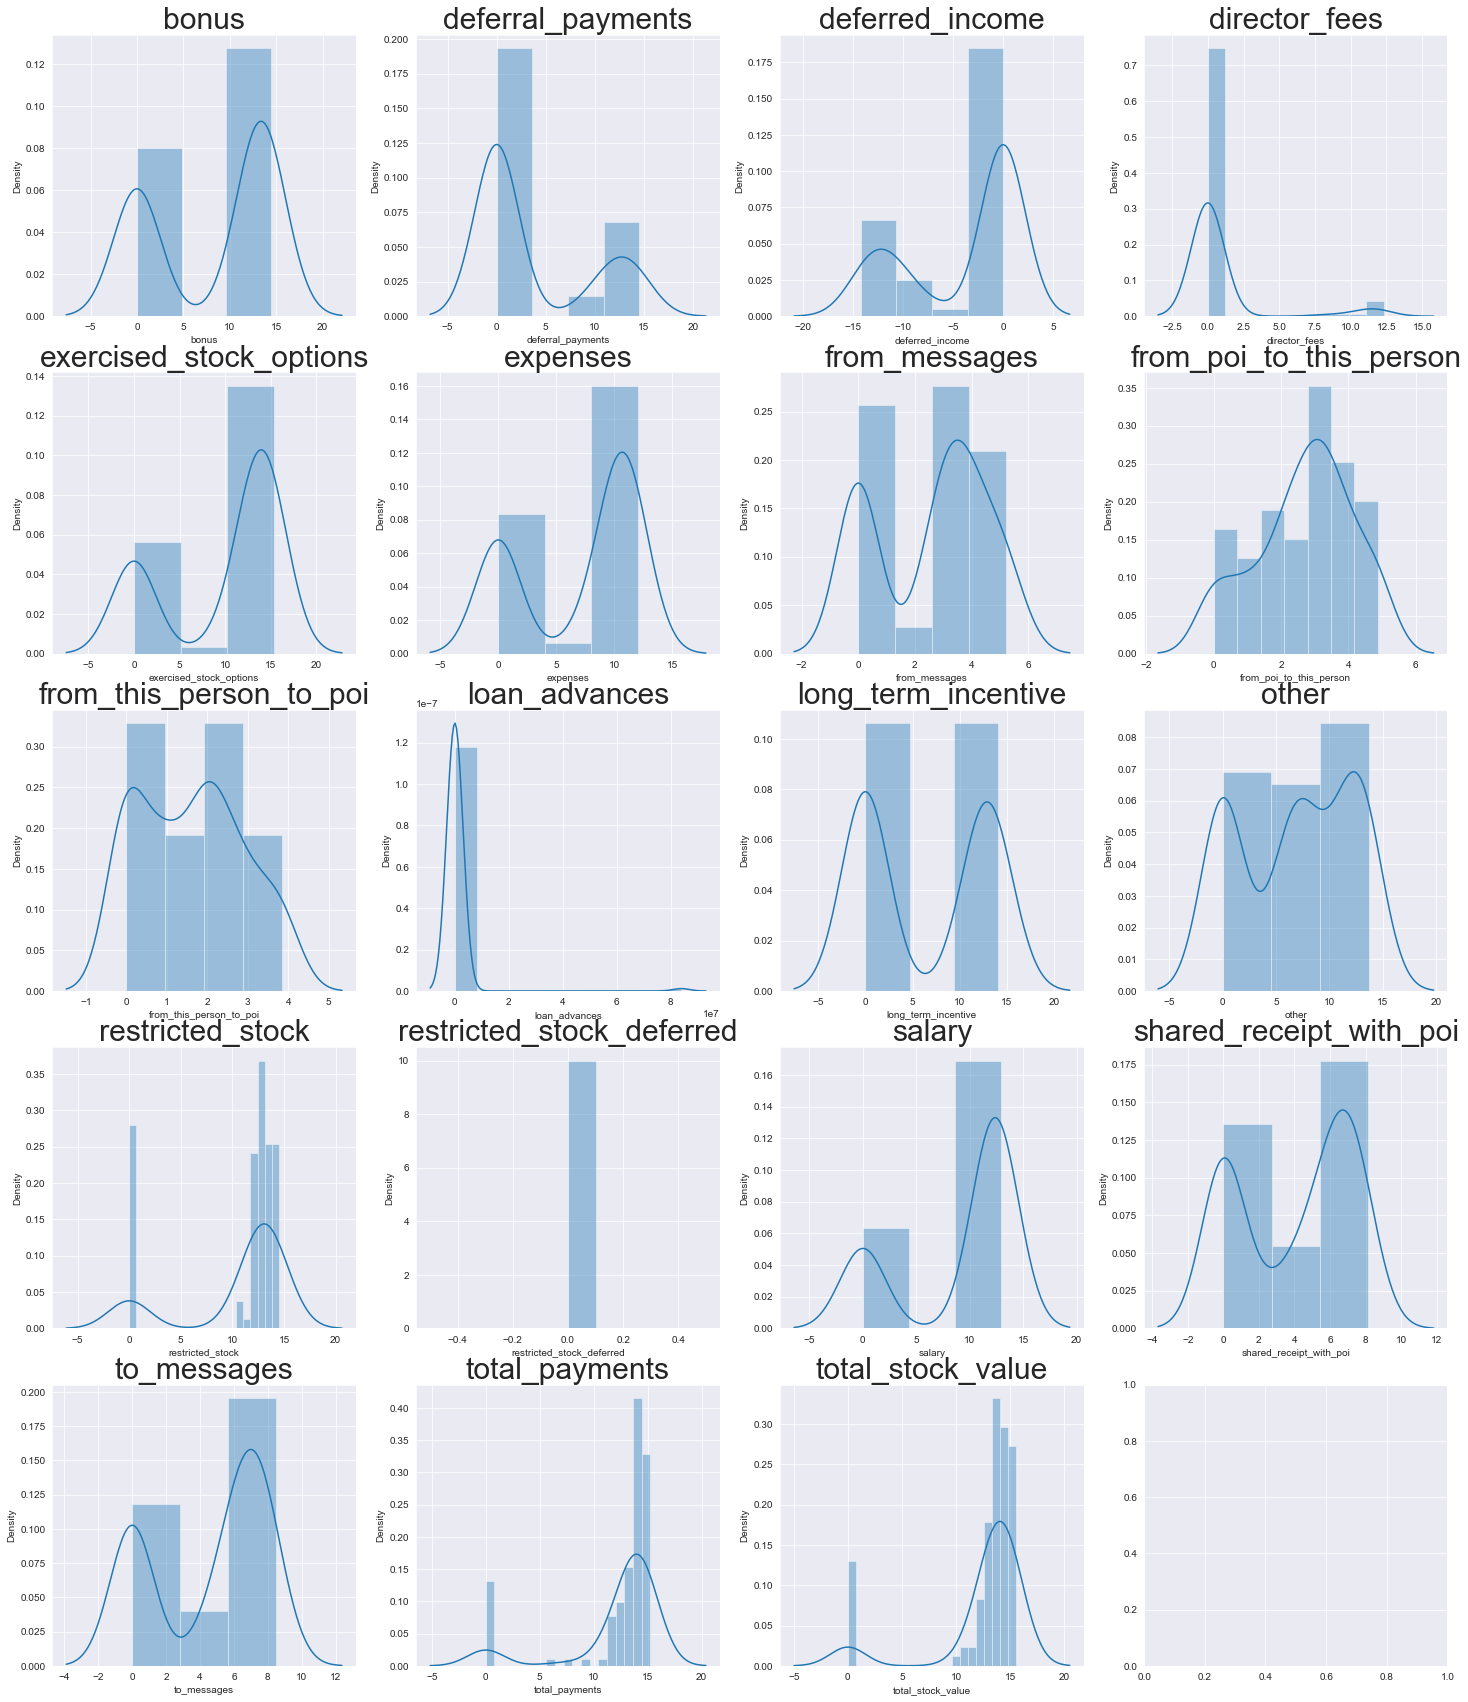

In [263]:
# 觀察修改後的特徵值
f, ax = plt.subplots(5,4, figsize=(25, 30))
sns.distplot(X['bonus'].dropna(), ax = ax[0, 0])
sns.distplot(X['deferral_payments'].dropna(), ax = ax[0, 1])
sns.distplot(X['deferred_income'].dropna(), ax = ax[0, 2])
sns.distplot(X['director_fees'].dropna(), ax = ax[0, 3])
sns.distplot(X['exercised_stock_options'].dropna(), ax = ax[1, 0])
sns.distplot(X['expenses'].dropna(), ax = ax[1, 1])
sns.distplot(X['from_messages'].dropna(), ax = ax[1, 2])
sns.distplot(X['from_poi_to_this_person'].dropna(), ax = ax[1, 3])
sns.distplot(X['from_this_person_to_poi'].dropna(), ax = ax[2, 0])
sns.distplot(X['loan_advances'].dropna(), ax = ax[2, 1])
sns.distplot(X['long_term_incentive'].dropna(), ax = ax[2, 2])
sns.distplot(X['other'].dropna(), ax = ax[2, 3])
sns.distplot(X['restricted_stock'].dropna(), ax = ax[3, 0])
sns.distplot(X['restricted_stock_deferred'].dropna(), ax = ax[3, 1])
sns.distplot(X['salary'].dropna(), ax = ax[3, 2])
sns.distplot(X['shared_receipt_with_poi'].dropna(), ax = ax[3, 3])
sns.distplot(X['to_messages'].dropna(), ax = ax[4, 0])
sns.distplot(X['total_payments'].dropna(), ax = ax[4, 1])
sns.distplot(X['total_stock_value'].dropna(), ax = ax[4, 2])

ax[0,0].set_title('bonus', fontsize = 30)
ax[0,1].set_title('deferral_payments', fontsize = 30)
ax[0,2].set_title('deferred_income', fontsize = 30)
ax[0,3].set_title('director_fees', fontsize = 30)
ax[1,0].set_title('exercised_stock_options', fontsize = 30)
ax[1,1].set_title('expenses', fontsize = 30)
ax[1,2].set_title('from_messages', fontsize = 30)
ax[1,3].set_title('from_poi_to_this_person', fontsize = 30)
ax[2,0].set_title('from_this_person_to_poi', fontsize = 30)
ax[2,1].set_title('loan_advances', fontsize = 30)
ax[2,2].set_title('long_term_incentive', fontsize = 30)
ax[2,3].set_title('other', fontsize = 30)
ax[3,0].set_title('restricted_stock', fontsize = 30)
ax[3,1].set_title('restricted_stock_deferred', fontsize = 30)
ax[3,2].set_title('salary', fontsize = 30)
ax[3,3].set_title('shared_receipt_with_poi', fontsize = 30)
ax[4,0].set_title('to_messages', fontsize = 30)
ax[4,1].set_title('total_payments', fontsize = 30)
ax[4,2].set_title('total_stock_value', fontsize = 30)

## 特徵工程
>1. 特徵建構: 從原始數據中人工的構建新的特徵，取代原始數據的特徵  
>2. 特徵提取: 將機器學習演算法不能識別的原始數據，轉化為演算法可以識別的特徵
    - 特徵提取的首要任務是將變數從文字轉換成數字，連續數值轉為離散數值，以利統計與導入演算法模型
>3. 特徵選擇: 從所有的特徵中選擇一組最好的特徵集，捨去無關的特徵，保留相關性高的特徵
    - 使用相關性作圖(Pearson相關係數)，顏色較淺的部分為沒有關係的，顏色偏藍就是正相關，顏色偏紅就是負相關，而我們在意的是與poi有相關性無論正負，若是值越接近0，即是要被剃除的特徵。

In [264]:
# 觀察是否為犯罪者在各特徵上之表現差異來給我們一些特徵建構的想法
X_train = X[:train_data.shape[0]]
X_test = X[train_data.shape[0]:]

#### 1. 特徵建構

In [265]:
# 將薪水與股票價值加總
X_train['total_incomes']= X_train['total_payments'] + X_train['total_stock_value']

# 將延期薪水與延期股票加總
X_train['total_deferred']= X_train['deferred_income'] + X_train['restricted_stock_deferred']

# 計算薪資總額
X_train['total_payments_recount'] = X_train['deferred_income'] + X_train['bonus'] + X_train['deferral_payments'] + X_train['director_fees'] + X_train['expenses'] + X_train['loan_advances'] + train_data['long_term_incentive']+ train_data['other'] +train_data['salary']
    
# 計算薪資總額誤差: 我自己算的跟資料集給的出現誤差, 表示有人作假帳 
X_train['total_payments_error'] = X_train['total_payments_recount'] - X_train['total_payments']

# 計算股票總和 
X_train['total_stock_value_recount'] = X_train['restricted_stock_deferred'] + X_train['exercised_stock_options'] + X_train['restricted_stock']

# 計算股票總和誤差
X_train['total_stock_value_error'] = X_train['total_stock_value_recount'] - X_train['total_stock_value']

# 計算email相關的總和
## 與犯罪者有關
X_train['total_poi_contact'] = X_train['from_poi_to_this_person'] + X_train['from_this_person_to_poi']
## 一般通聯記錄
X_train['total_messages'] = X_train['from_messages'] + X_train['to_messages']

# 計算與犯罪者聯絡的密集度與一般聯絡的比例
## 收到郵件之比例
X_train['from_poi_contact_rate'] = X_train['from_poi_to_this_person'] / (1.0 + X_train['from_poi_to_this_person'] + X_train['from_messages'])
## 寄出郵件之比例
X_train['to_poi_contact_rate'] = X_train['from_this_person_to_poi'] / (1.0 + X_train['from_this_person_to_poi'] + X_train['to_messages'])

X_train.shape

(81, 29)

#### 2. 特徵提取

In [266]:
# 觀察資料分布
X.describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,1.140000e+02,114.000000,114.000000,114.000000,114.0,114.000000,114.000000,114.000000,114.000000,114.000000
mean,8.196682,3.738029,-4.023365,0.867015,9.799545,6.983794,2.550281,2.702005,1.606371,7.572368e+05,6.449796,6.905031,10.525090,0.0,9.005785,4.051798,4.540283,12.187911,12.581427
std,6.552114,5.824626,5.724045,2.995042,6.383531,5.048209,1.948663,1.421837,1.277311,7.860621e+06,6.505174,5.211609,5.238406,0.0,5.537922,3.164550,3.342149,4.430837,4.273490
min,0.000000,0.000000,-14.249871,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-10.519407,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000e+00,0.000000,0.000000,11.744259,0.0,0.000000,0.000000,0.000000,12.464547,12.834690
50%,12.691584,0.000000,0.000000,0.000000,13.397087,10.059328,3.043387,3.000000,1.868835,0.000000e+00,5.572551,7.310411,12.825700,0.0,12.279730,5.235295,6.237267,13.872105,13.827163
75%,13.588828,10.879025,0.000000,0.000000,14.305636,10.922729,3.955725,3.688879,2.620530,0.000000e+00,12.835494,12.097442,13.457050,0.0,12.511432,6.769027,7.322457,14.466662,14.633735
max,14.457365,14.521293,0.000000,12.318115,15.385118,11.999641,5.201256,4.875197,3.842137,8.392500e+07,14.117738,13.710187,14.499672,0.0,12.912977,8.148663,8.478270,15.241815,15.515242


In [267]:
# 將這些數值特徵分成五等分，精簡模型的數值分析，並做 LabelEncoder
for column in X.columns:
    X[column] = pd.cut(X[column], 5)
    X[column] = LabelEncoder().fit_transform(X[column])
X.head(10)

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,2,0,2,0,3,3,2,2,3,0,0,4,2,0,1,2,2,3,2
1,2,0,3,0,0,3,0,3,2,0,2,4,2,0,1,0,0,3,2
2,2,0,0,0,0,3,3,4,4,0,2,2,2,0,1,4,3,3,1
3,0,1,3,0,3,3,0,1,0,0,0,2,0,0,0,0,0,2,2
4,0,0,3,0,3,3,0,3,2,0,0,4,2,0,1,0,0,3,2
5,2,1,0,0,0,3,2,4,3,0,0,4,2,0,1,4,3,3,2
6,2,0,3,0,3,3,1,4,2,0,1,4,2,0,1,4,2,3,2
7,2,0,3,0,3,3,2,4,3,0,2,4,2,0,1,4,3,3,2
8,2,2,0,0,3,3,3,3,4,0,0,2,2,0,1,4,3,3,2
9,2,0,0,0,0,3,0,3,2,0,2,4,2,0,1,0,0,3,2


#### 3.特徵選擇
- 使用皮爾遜積差相關係數來做特徵選擇

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

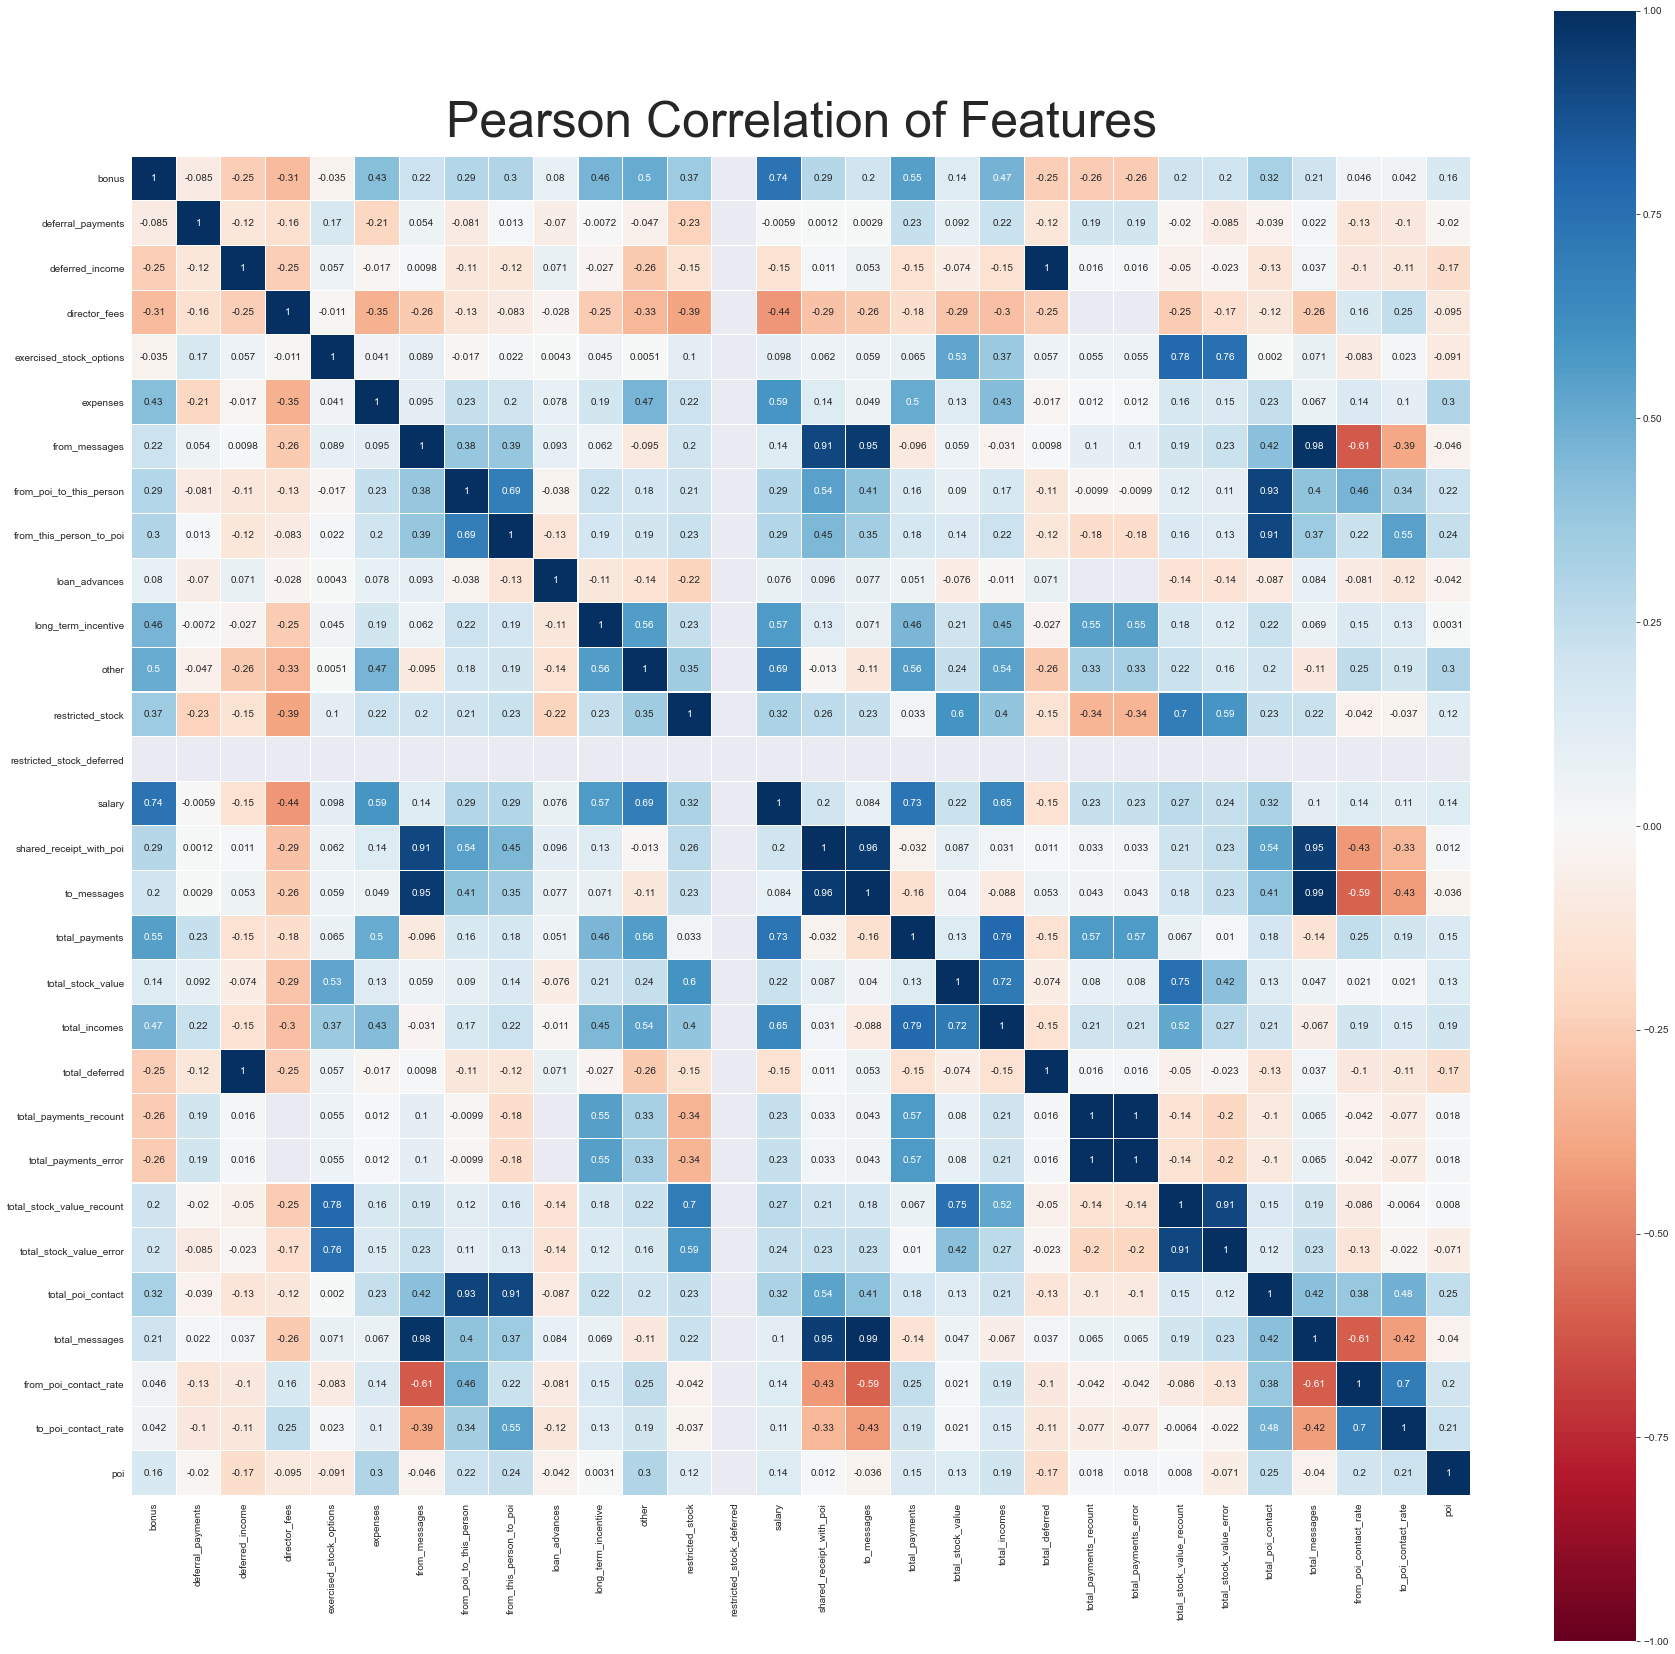

In [268]:
# 因為剛剛把 poi 移除了, 所以先加回來判斷相關係數
train = pd.concat([X_train, pd.DataFrame(y_train)], axis = 1)

# 先建立空圖
colormap = plt.cm.RdBu
plt.figure(figsize = (30, 30))
plt.title('Pearson Correlation of Features', y = 1.01, size = 50)

# 再將資料加入圖中
sns.heatmap(train.astype(float).corr(), linewidths = 0.1, vmin = -1.0 ,vmax = 1.0, square = True, cmap = colormap, 
            linecolor = 'white', annot = True, xticklabels = True, yticklabels = True)

In [269]:
# 觀察相關性
train.astype(float).corr()['poi']

bonus                        0.163090
deferral_payments           -0.020298
deferred_income             -0.174539
director_fees               -0.095361
exercised_stock_options     -0.090888
expenses                     0.302889
from_messages               -0.045808
from_poi_to_this_person      0.218438
from_this_person_to_poi      0.240001
loan_advances               -0.041959
long_term_incentive          0.003066
other                        0.301728
restricted_stock             0.117829
restricted_stock_deferred         NaN
salary                       0.135995
shared_receipt_with_poi      0.012053
to_messages                 -0.036214
total_payments               0.148756
total_stock_value            0.133072
total_incomes                0.187593
total_deferred              -0.174539
total_payments_recount       0.018182
total_payments_error         0.018182
total_stock_value_recount    0.007994
total_stock_value_error     -0.071386
total_poi_contact            0.248616
total_messag

In [270]:
# 取得相關性絕對值大於 0.2 的特徵
feature_select = []
for i in range(len(train.astype(float).corr()['poi'])):
    if abs(train.astype(float).corr()['poi'].values[i] >= 0.10):
        feature_select.append(train.astype(float).corr()['poi'].index[i])

# 刪除較不相關的欄位
for column in X.columns:
    if column not in feature_select:
        X = X.drop([column], axis = 1)
        
# 觀察修正後的訓練資料尺寸
print(f'X shape: {X.shape}')

X shape: (114, 9)


## 建立模型
- 建立需要用到的模型, 再利用交叉驗證判斷好壞

In [271]:
X_train = X[:train_data.shape[0]]
y_train = np.ravel(y_train)
X_test = X[train_data.shape[0]:]
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (81, 9)
y_train shape: (81,)
X_test shape: (33, 9)


In [272]:
X_train_mm = X_train
X_test_mm = X_test


# mm = MinMaxScaler().fit(X_train)
# X_train_mm = mm.transform(X_train)
# X_test_mm = mm.transform(X_test)

### 訓練模型

In [273]:

rf = RandomForestRegressor(n_estimators=300, min_samples_split=9, min_samples_leaf=10, 
                           max_features='sqrt', max_depth=8, bootstrap=False)

# XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

# LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


In [274]:
# 測試訓練資料
from sklearn.metrics import roc_auc_score

rf.fit(X_train_mm, y_train)
rf_pred = np.expm1(rf.predict(X_train_mm))

model_xgb.fit(X_train_mm, y_train)
xgb_pred = np.expm1(model_xgb.predict(X_train_mm))

model_lgb.fit(X_train_mm, y_train)
lgb_pred = np.expm1(model_lgb.predict(X_train_mm))

# 混合泛化預測檔 (依 Kaggle 傳回分數調整比重, 越準確者比重越高, 依資料性質有所不同)
blending_pred = rf_pred*0.25 + xgb_pred*0.15 + lgb_pred*0.6
train_auc = roc_auc_score(y_train, blending_pred)
train_auc

[17:40:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


0.9746478873239437

In [275]:
rf.fit(X_train_mm, y_train)
rf_pred = np.expm1(rf.predict(X_test_mm))

model_xgb.fit(X_train_mm, y_train)
xgb_pred = np.expm1(model_xgb.predict(X_test_mm))

model_lgb.fit(X_train_mm, y_train)
lgb_pred = np.expm1(model_lgb.predict(X_test_mm))

# 混合泛化預測檔 (依 Kaggle 傳回分數調整比重, 越準確者比重越高, 依資料性質有所不同)
blending_pred = rf_pred*0.25 + xgb_pred*0.15 + lgb_pred*0.6

[17:40:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


### 測試模型並輸出

In [276]:
sub = pd.read_csv('./data/Enron Fraud/sample_submission.csv')
submission = pd.DataFrame()
submission['name'] = sub['name']
submission['poi'] = rf_pred 
submission.to_csv('./data/Enron Fraud/submission_blending.csv', index = False)